In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  4 07:02:45 2024

@author: robberto
"""

from astropy.io import fits
import matplotlib.pyplot as plt

import os
import shutil
import glob
import numpy as np
import pandas as pd
import copy
import heapq

from scipy.signal import find_peaks
import cv2

## """ Instantiate the class with the correct directory name"""

In [2]:
# data_path = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/2017.SAMOS/_Run5/SAMI"
data_path = "/Users/nestrada/Documents/SAMOS/_Run2"

from Class_SAMOS import SAMOS
SAMOS = SAMOS(data_path) 

ModuleNotFoundError: No module named 'Class_SAMOS'

### Check the files you want to process here
https://www.stsci.edu/~robberto/Main/SAMOS/Run_October2024/SAMI/QL_20241017/overview.html

## SELECT A TARGET AND INSPECT THE FILES YOU MAY WANT TO USE. ANNOTATE BELOW

In [3]:
# DATA ANALYSIS 
#target_name = "ABELL3120_manual_Mask_T00_Low_Red"
# DATA ANALYSIS 
target_name = "ABELL3120"
target_mode = "SAMI_manual_Mask_T00_Low_Red"

"""
=> Night 20241017
TARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]
FLATS  = target.028.fits [2s], calibration.029.fits [2s]
ARC_Ne = calibration.033.fits [10s]
ARC_HgAr = calibration.030.fits [8s]
ARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  
ARC_Ne_DMDoff = calibration.034.fits [8s]
ARC_HgAr_DMDoff = calibration.036.fits [8s]
ARC_HgArNe_DMDoff = calibration.035.fits [8s]

=> Night 20241016
BIAS =  bias.055.fits - bias.074.fits 

=> Night 20241016
FLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]
"""

'\n=> Night 20241017\nTARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]\nFLATS  = target.028.fits [2s], calibration.029.fits [2s]\nARC_Ne = calibration.033.fits [10s]\nARC_HgAr = calibration.030.fits [8s]\nARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  \nARC_Ne_DMDoff = calibration.034.fits [8s]\nARC_HgAr_DMDoff = calibration.036.fits [8s]\nARC_HgArNe_DMDoff = calibration.035.fits [8s]\n\n=> Night 20241016\nBIAS =  bias.055.fits - bias.074.fits \n\n=> Night 20241016\nFLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]\n'

In [4]:
#CREATE A WORKING DIRECTORY WITH THE TARGET NAME IF IT DOES NOT EXIST
#working_directory ="/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS"
#working_directory = os.path.join(working_directory,target_name)
#CREATE A WORKING DIRECTORY WITH THE TARGET NAME IF IT DOES NOT EXIST
#analysis_top_directory ="/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS"
analysis_top_directory ="/Users/nestrada/Documents/SAMOS/Pipeline/Nicolas_01"

working_directory = os.path.join(analysis_top_directory,target_name,target_mode)

# if the folder already exists in new directory
if not os.path.exists(working_directory):
        os.makedirs(working_directory)
os.chdir(working_directory) 
print(working_directory)

#DATA DIRECTORIES WHERE THE SAMOS FILES ARE STORED
data_directory = "/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI"
data_directory_17 = data_directory + "/20241017"
data_directory_16 = data_directory + "/20241016"
data_directory_09 = data_directory + "/20241009"

/Users/nestrada/Documents/SAMOS/Pipeline/Nicolas_01/ABELL3120/SAMI_manual_Mask_T00_Low_Red


## READ THE TARGET SPECTRA

In [5]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "TARGET"
File_NR = '027'
file  = os.path.join(data_directory_17,'target.'+File_NR+'.fits')
print(file)

hdu = SAMOS.read_SAMI_mosaic(file)
Target_Spectra = hdu.data
hdu.data = Target_Spectra

/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241017/target.027.fits


In [6]:
print(hdu.header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 4094                                                  NAXIS2  =                 1428                                                  COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy andCOMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.COMMENT   Contact the NASA Science Office of Standards and Technology for the   COMMENT   FITS Definition document #100 and other FITS information.             NEXTEND =                    4 / Number of extensions                           FILENAME= '/home2/images/20241017/target.027' / Original host filename          OBJECT  = 'ABELL3120 manual Mask T00 Low Red' / Observation title               OBSTYPE = 'OBJECT  '           / Observa

In [7]:
#make a copy of the invoice to work with
destination=File_type+'.fits'
shutil.copy(file,destination)
#hdul = fits.HDUList([hdu]) ; hdul.writeto(destination,overwrite=True)

'TARGET.fits'

In [8]:
#correct for cosmic rays with la_cosmic
spectra = SAMOS.CR_correct(Target_Spectra)

INFO: Iteration 1: Found 1280 cosmic-ray pixels, Total: 1280 [lacosmic.core]
INFO: Iteration 2: Found 65 cosmic-ray pixels, Total: 1345 [lacosmic.core]
INFO: Iteration 3: Found 8 cosmic-ray pixels, Total: 1353 [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 1353 [lacosmic.core]


(1428, 4094)


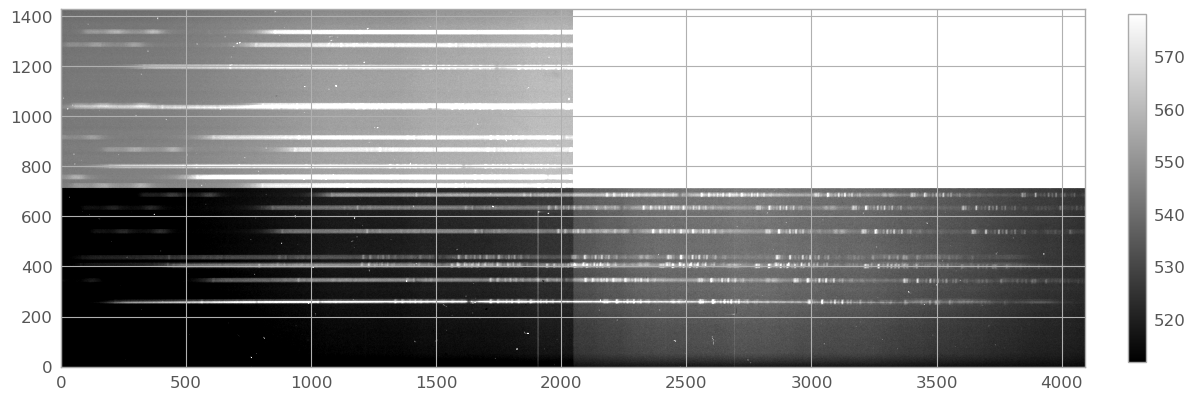

In [9]:
# display setting the limits for the gray scale
median = np.median(spectra)
stddev = np.std(spectra)
z0 = median-stddev
z1 = median+stddev
print(spectra.shape)
SAMOS.display_image(spectra,zmin=z0,zmax=z1)

## FLATS AND BIAS


INFO: Iteration 1: Found 627 cosmic-ray pixels, Total: 627 [lacosmic.core]
INFO: Iteration 2: Found 119 cosmic-ray pixels, Total: 746 [lacosmic.core]
INFO: Iteration 3: Found 34 cosmic-ray pixels, Total: 780 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 792 [lacosmic.core]


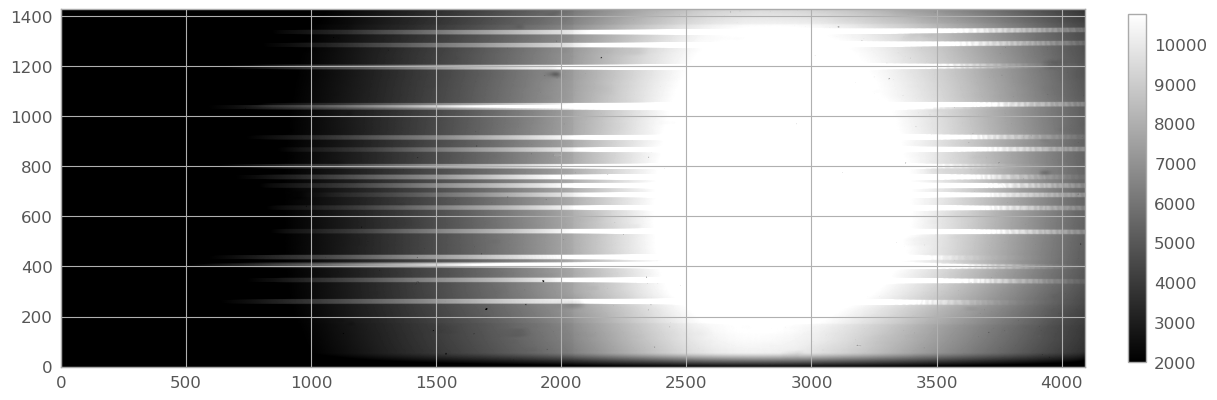

In [10]:
#SET THE FILE NAMES
File_type = "FLAT"
File_NR = '028'
file1  = os.path.join(data_directory_17,'target.'+File_NR+'.fits')
File_NR = '029'
file2  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')

#SECOND STEP: READ AND AVERAGE
hdu = SAMOS.read_SAMI_mosaic(file1)
flat1_data = hdu.data
hdu.data = flat1_data

hdu1 = SAMOS.read_SAMI_mosaic(file2)
flat2_data = hdu1.data
hdu1.data = flat2_data
flat = ( flat1_data+flat2_data ) / 2

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
flat = SAMOS.CR_correct(flat)

#DISPLAY
median = np.median(flat)
stddev = np.std(flat)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat,zmin=z0,zmax=z1)

1997.438307983335 10765.561692016665


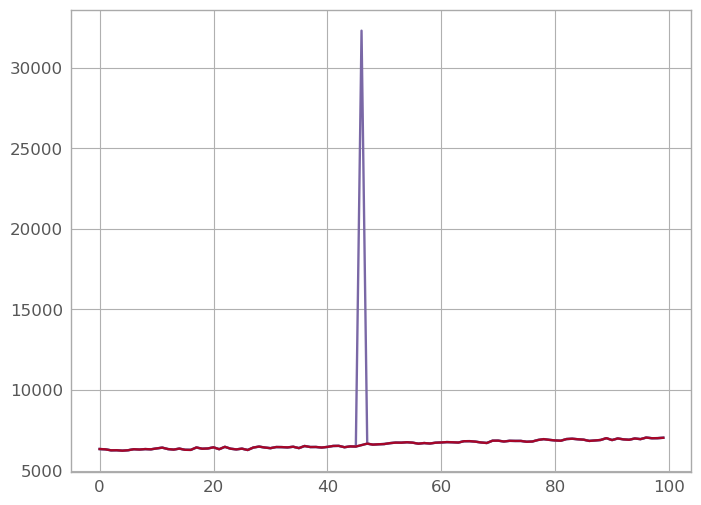

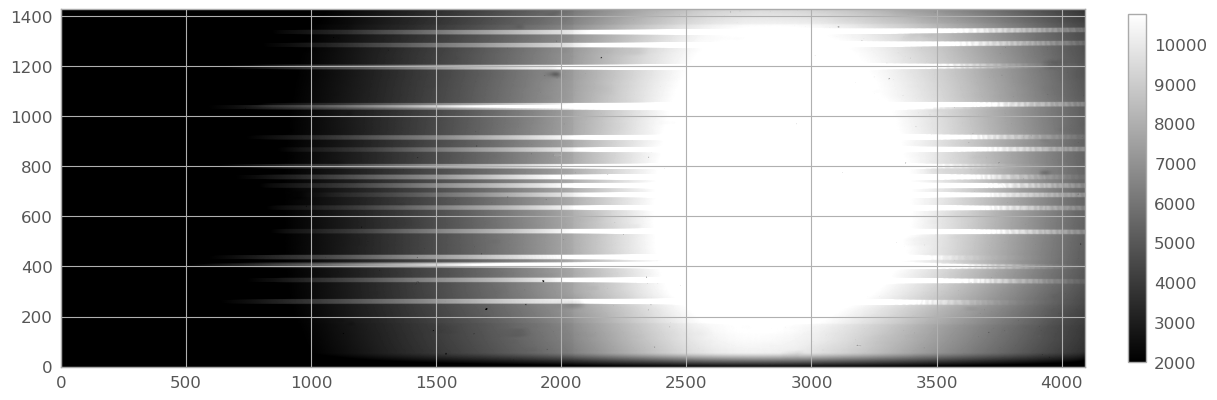

In [11]:
flat1 = copy.deepcopy(flat)
print(z0,z1)
flat1[:,2046]=z1*3
plt.plot(flat[100,2000:2100])
plt.plot(flat1[100,2000:2100])
flat2 = flat1
flat2[:,2046] = (flat1[:,2045]+flat1[:,2047])/2
plt.plot(flat2[100,2000:2100])
SAMOS.display_image(flat2,zmin=z0,zmax=z1)

In [34]:
print((flat1[100,:]).shape)

(4094,)


## Now the BIAS frames

/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.055.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.056.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.057.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.058.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.059.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.060.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.061.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.062.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.063.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.064.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.065.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.066.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.067.fits
/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241016/bias.068.fits
/Users

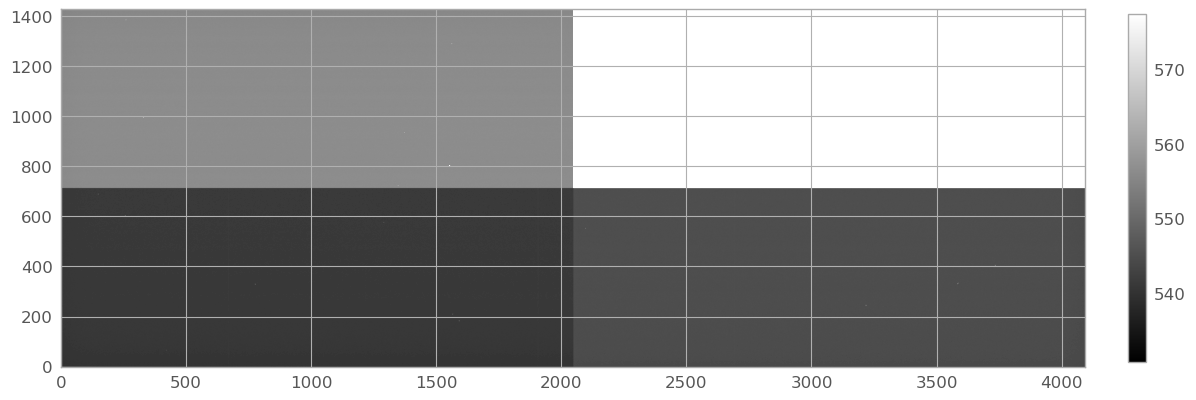

In [12]:
#FIRST STEP: SET THE FILE NAMES
File_type = "BIAS"

File_NR = ['055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074']
biases = np.zeros( (len(File_NR),1428,4094) )
for i in range(len(File_NR)):
    file = os.path.join(data_directory_16,'bias.'+File_NR[i]+'.fits')
    print(file)
    hdu = SAMOS.read_SAMI_mosaic(file)
    biases[i,:,:] = hdu.data
bias = biases.sum(axis=0)/len(File_NR)
bias.shape

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
bias = SAMOS.CR_correct(bias)

#DISPLAY
median = np.median(bias)
stddev = np.std(bias)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(bias,zmin=z0,zmax=z1)

## SUBTRACT THE BIAS FROM THE FLAT

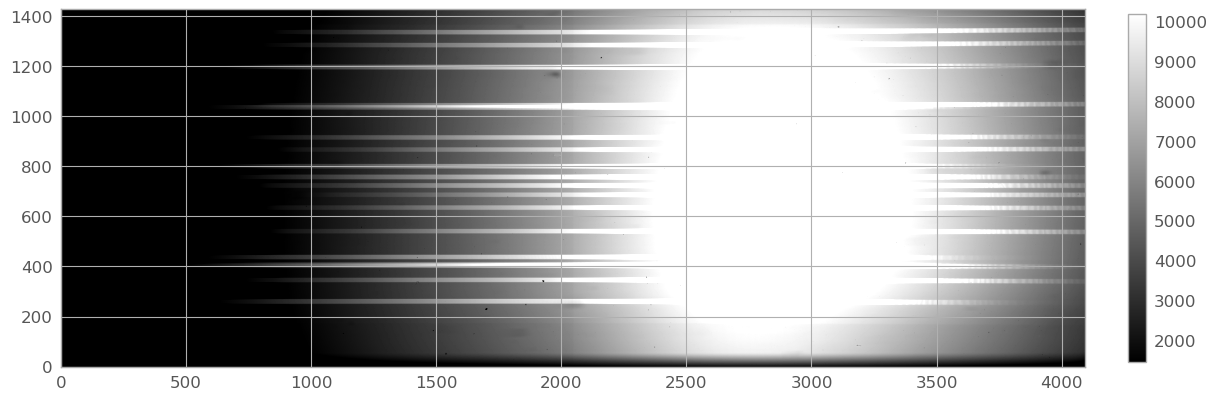

In [13]:
flat_bias = flat - bias

#DISPLAY
median = np.median(flat_bias)
stddev = np.std(flat_bias)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat_bias,zmin=z0,zmax=z1)

## SUBTRACT THE BIAS FROM THE SPECTRA

-15.912818659015194
-0.48718134098489685


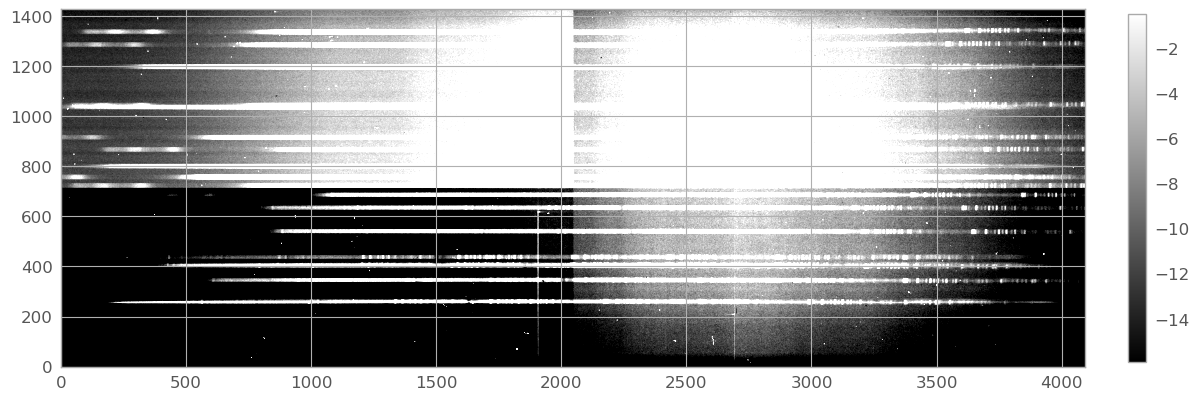

In [14]:
spectra_bias = spectra - bias

#DISPLAY
median = np.median(spectra_bias)
stddev = np.std(spectra_bias)
z0 = median-stddev/2  ; print(z0)
z1 = median+stddev/2  ; print(z1)

SAMOS.display_image(spectra_bias,zmin=z0,zmax=z1)

### There is clearly a problem with the bias, taken on a different night. 
### Also the quartz with all DMD open was taken on the previous night and does not subtract nicely. 
### This makes finding the traces difficult. 

4094
4094 1428
5.0 0.0 5.0 0.0


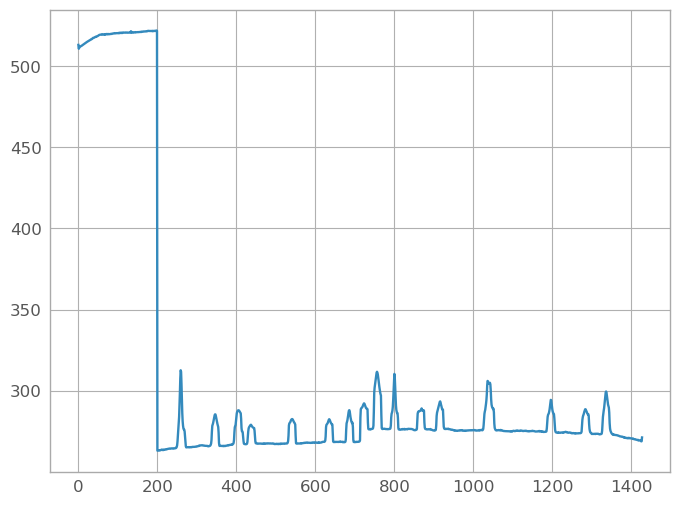

In [15]:
#should we ignore the bias and corect the spectra with their own "bias"
dx = spectra.shape[1] ; print(dx)
dy = spectra.shape[0]
print(dx,dy)
dy2=int(dy/2)
dx2=int(dx/2)

spectra_selfbias = copy.deepcopy(spectra)
spectra_selfbias[200:dy2,:dx2] = spectra[200:dy2,:dx2] - np.median(spectra[200:dy2,:dx2]) 
spectra_selfbias[dy2:,dx2:] = spectra[dy2:,dx2:] - np.median(spectra[dy2:,dx2:]) 
spectra_selfbias[200:dy2,:dx2] = spectra[200:dy2,:dx2] - np.median(spectra[200:dy2,:dx2]) 
spectra_selfbias[dy2:,dx2:] = spectra[dy2:,dx2:] - np.median(spectra[dy2:,dx2:])
print(np.median(spectra_selfbias[:dy2,:dx2]), np.median(spectra_selfbias[dy2:,dx2:]), np.median(spectra_selfbias[:dy2,:dx2]), np.median(spectra_selfbias[dy2:,dx2:]))
s_sb = (spectra_selfbias).mean(axis=1)
plt.plot(s_sb)
plt.show()

## GO WITH ARC LAMP

/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241017/calibration.032.fits
INFO: Iteration 1: Found 37263 cosmic-ray pixels, Total: 37263 [lacosmic.core]
INFO: Iteration 2: Found 8640 cosmic-ray pixels, Total: 45903 [lacosmic.core]
INFO: Iteration 3: Found 2688 cosmic-ray pixels, Total: 48591 [lacosmic.core]
INFO: Iteration 4: Found 1366 cosmic-ray pixels, Total: 49957 [lacosmic.core]


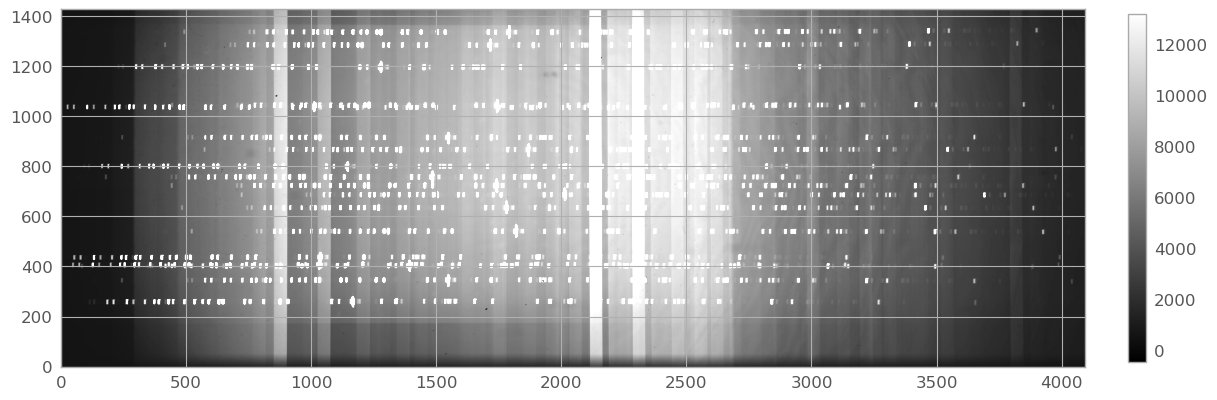

In [16]:
#FIRST STEP: SET THE FILE NAMES
File_type = "ARC"

File_NR = '032'
file  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')
print(file)

hdu = SAMOS.read_SAMI_mosaic(file)
arc = hdu.data

#SAVE
hdul = fits.HDUList([hdu]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
arc = SAMOS.CR_correct(arc)

#DISPLAY
median = np.median(arc)
stddev = np.std(arc)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(arc,zmin=z0,zmax=z1)

### FOR THIS ARC WE HAVE ITS OWN "DARK", ILLUMINATION WITH NO DMD OPEN 

/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241017/calibration.035.fits
INFO: Iteration 1: Found 1355 cosmic-ray pixels, Total: 1355 [lacosmic.core]
INFO: Iteration 2: Found 135 cosmic-ray pixels, Total: 1490 [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 1522 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 1528 [lacosmic.core]


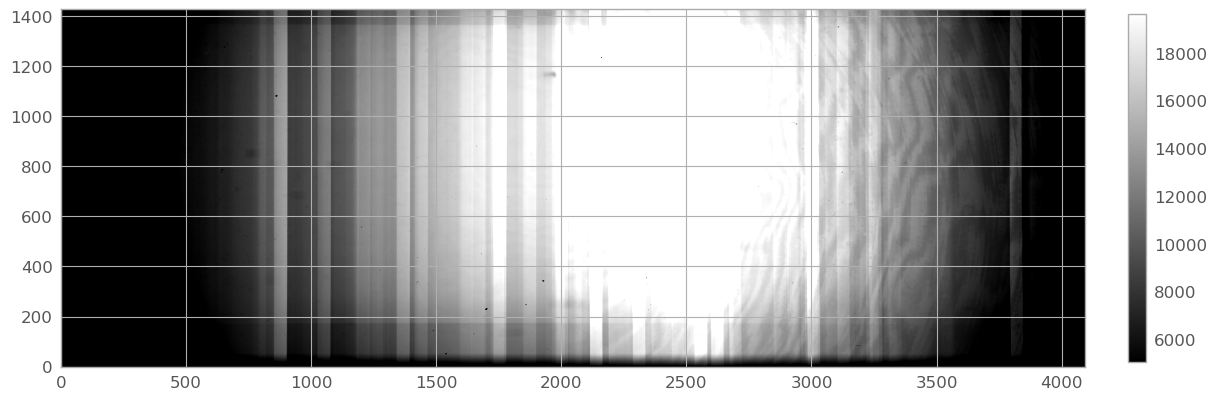

In [17]:
File_type = "ARC_noDMD"

File_NR = '035'
file  = os.path.join(data_directory_17,'calibration.'+File_NR+'.fits')
print(file)

hdu_noDMD = SAMOS.read_SAMI_mosaic(file)
arc_noDMD = hdu_noDMD.data
#SAVE
hdul = fits.HDUList([hdu_noDMD]) ; hdul.writeto(File_type+'.fits',overwrite=True)

#correct for cosmic rays
arc_noDMD = SAMOS.CR_correct(arc_noDMD)

#DISPLAY
median = np.median(arc_noDMD)
stddev = np.std(arc_noDMD)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(arc_noDMD,zmin=z0,zmax=z1)

### THE SUBTRACION IS VERY GOOD

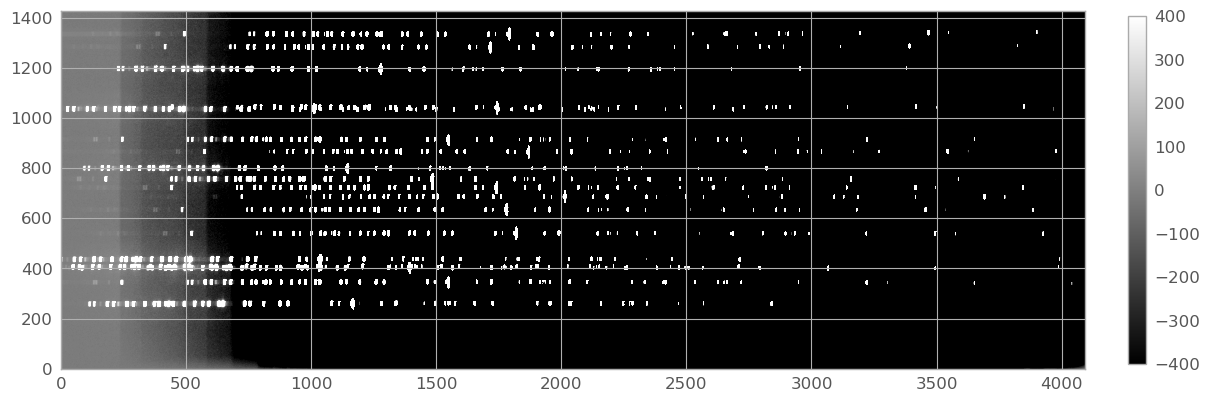

In [18]:
arc_good = arc-arc_noDMD
SAMOS.display_image(arc_good,zmin=-400,zmax=400)

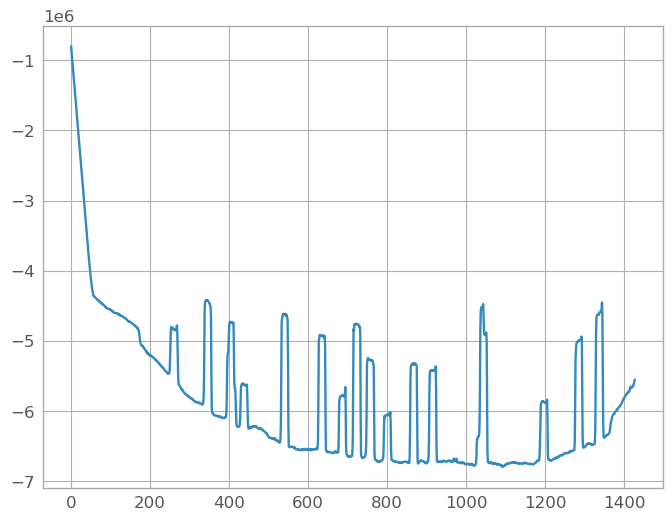

In [19]:
#Check the coadded rows
plt.plot(arc_good[:,2500:3000].sum(axis=1))

# Nicely sharp. Looks great. We can use the arc to find the traces!

# Find the traces

4094


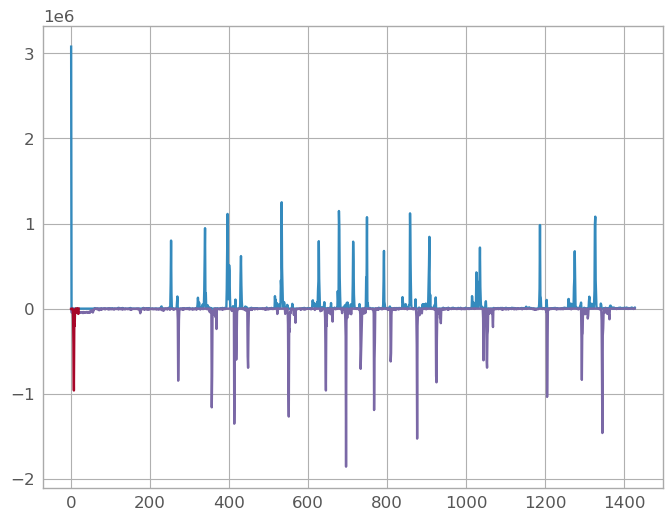

In [20]:
dx = arc_good.shape[1] ; print(dx)
dy = arc_good.shape[0]
mask = np.zeros((dy,dx))
cut = arc_good[:,1500:2000].sum(axis=1)
cut1 = np.roll(cut,+1)
diff=cut-cut1
diff_neg = copy.deepcopy(diff)
diff_neg[diff > 0] =0 
diff_pos = copy.deepcopy(diff)
diff_pos[diff < 0] = 0
#match = diff_pos * (-np.roll(diff_neg,-8))
plt.plot(diff_pos)#[620:640])
plt.plot(diff_neg)#[620:640])
plt.plot(np.roll(diff_neg,-18)[620:640])


plt.show()


### Find some peaks using the smoothing parameter.
fp = findpeaks(lookahead=1, interpolate=3) results = fp.fit(diff_pos)

In [21]:
peak_threshold = 4E5
v_slit_up, _ = find_peaks(diff_pos, distance=3,height=peak_threshold)
print(v_slit_up)
v_slit_down, _ = find_peaks(-diff_neg, distance=3,height=peak_threshold)
print(v_slit_down)


[ 253  339  396  400  430  533  627  678  714  749  792  858  907 1026
 1035 1187 1275 1327]
[ 271  356  413  418  448  551  645  696  733  767  809  876  925 1044
 1053 1205 1293 1345]


# ... there is no problem with the pairing of the edges.
# however there are slits too close to each other. Remove some entry...

In [22]:
to_be_removed = []
for i in range (1,len(v_slit_up)):
    #print(v_slit_up[i],v_slit_down[i])
    try:
        print(v_slit_up[i+1])
    except:
        continue
    if (v_slit_down[i] > v_slit_up[i+1]):
        print(v_slit_up[i],v_slit_down[i],"conflict! remove i =",i)
        to_be_removed.append(i)
    if (v_slit_down[i-1] > v_slit_up[i]):
        print(v_slit_up[i],v_slit_down[i],"conflict! remove i =",i)
        to_be_removed.append(i)
    else:    
        print(v_slit_up[i],v_slit_down[i])
print('to_be_removed = ',to_be_removed)
print(len(v_slit_up))
v_slit_up=np.delete(v_slit_up, to_be_removed,axis=0) 
v_slit_down=np.delete(v_slit_down, to_be_removed, axis=0)
print(len(v_slit_up))

print("\nCHECK:")
good_slits = []
for i in range (len(v_slit_up)):
    print(i,v_slit_up[i],v_slit_down[i])
    good_slits.append(i)

396
339 356
400
396 413 conflict! remove i = 2
396 413
430
400 418 conflict! remove i = 3
533
430 448
627
533 551
678
627 645
714
678 696
749
714 733
792
749 767
858
792 809
907
858 876
1026
907 925
1035
1026 1044 conflict! remove i = 13
1026 1044
1187
1035 1053 conflict! remove i = 14
1275
1187 1205
1327
1275 1293
to_be_removed =  [2, 3, 13, 14]
18
14

CHECK:
0 253 271
1 339 356
2 430 448
3 533 551
4 627 645
5 678 696
6 714 733
7 749 767
8 792 809
9 858 876
10 907 925
11 1187 1205
12 1275 1293
13 1327 1345


#v_slit_up=np.delete(v_slit_up, 1, axis=0)
print(v_slit_up[:,1], len(v_slit_up[:,1]))
slit_up = v_slit_up[:,1]

v_slit_down=np.delete(v_slit_down, 5, axis=0)
print(v_slit_down[:,1], len(v_slit_down[:,1]))
slit_down = v_slit_down[:,1]
plt.scatter(v_slit_up[:,1],v_slit_down[:,1],c='blue')

## Good. We can now define the slits

In [23]:
slits=[]
for i in range(len(v_slit_up)):
    slits.append([v_slit_up[i],v_slit_down[i]])
    print("slit",i,"with dy =", v_slit_down[i]-v_slit_up[i])
print("that we can call using e.g. slits[5]:",slits[5])


slit 0 with dy = 18
slit 1 with dy = 17
slit 2 with dy = 18
slit 3 with dy = 18
slit 4 with dy = 18
slit 5 with dy = 18
slit 6 with dy = 19
slit 7 with dy = 18
slit 8 with dy = 17
slit 9 with dy = 18
slit 10 with dy = 18
slit 11 with dy = 18
slit 12 with dy = 18
slit 13 with dy = 18
that we can call using e.g. slits[5]: [678, 696]


## BETTER: we also set the limits of the adjacent field edges:

In [24]:
slits=[]
for i in range(len(v_slit_up)):
    #print([slit_up[i],slit_down[i]])
    if i ==0:
        s0 = v_slit_up[i]-12
    else:    
        s0 = np.max([v_slit_down[i-1],v_slit_up[i]-12])
    if  i == len(v_slit_down)-1:
        s1 = v_slit_down[i]+12
    else:
        s1 = np.min([v_slit_up[i+1],v_slit_down[i]+12])
#    print([s0,slit_up[i],slit_down[i],s1])   
    slits.append([s0,v_slit_up[i],v_slit_down[i],s1])
    print("slit",i,"with dy =",s1-s0)

print("So the slit[0] is:",slits[2])

slit 0 with dy = 42
slit 1 with dy = 41
slit 2 with dy = 42
slit 3 with dy = 42
slit 4 with dy = 42
slit 5 with dy = 42
slit 6 with dy = 43
slit 7 with dy = 42
slit 8 with dy = 41
slit 9 with dy = 42
slit 10 with dy = 42
slit 11 with dy = 42
slit 12 with dy = 42
slit 13 with dy = 42
So the slit[0] is: [418, 430, 448, 460]


## so basically we have found the traces

## FROM THIS POINT ON ONE COULD PROCEED WITH A LOOP.
## HERE WE DEMONSTRATE PROCEDURE FOR A SINGLE SLIT Nr 10

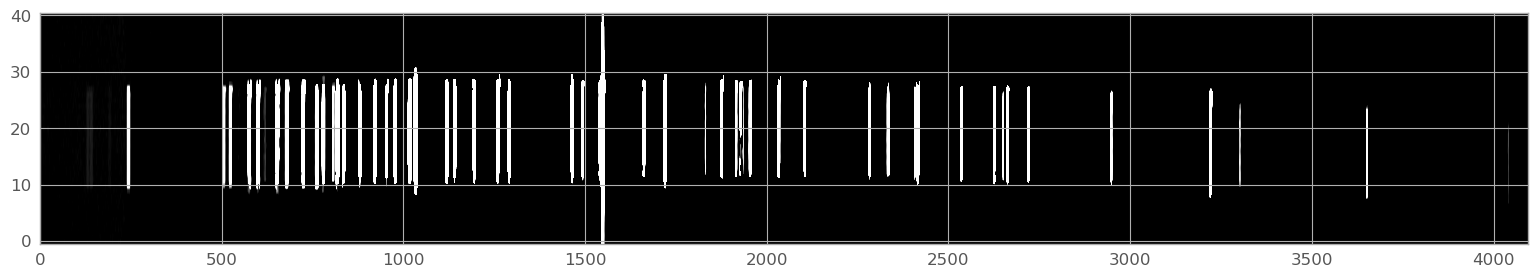

[327, 339, 356, 368] (41, 4094)


In [25]:
i_slit=1
#arc_good = arc-arc_noDMD
#plt.imshow(image, origin='lower', cmap='gray',vmin=zmin, vmax=zmax)

plt.figure(figsize=(20,3))
plt.imshow(arc_good[slits[i_slit][0]:slits[i_slit][3],:], origin='lower', cmap='gray',vmin=0, vmax=1000,aspect='15.5')
#plt.gca().set_aspect(0.5)
plt.show()
print(slits[i_slit],arc_good[slits[i_slit][0]:slits[i_slit][3],:].shape)

# Plot all slits

[241, 253, 271, 283] (42, 4094)
[327, 339, 356, 368] (41, 4094)
[418, 430, 448, 460] (42, 4094)
[521, 533, 551, 563] (42, 4094)
[615, 627, 645, 657] (42, 4094)
[666, 678, 696, 708] (42, 4094)
[702, 714, 733, 745] (43, 4094)
[737, 749, 767, 779] (42, 4094)
[780, 792, 809, 821] (41, 4094)
[846, 858, 876, 888] (42, 4094)
[895, 907, 925, 937] (42, 4094)
[1175, 1187, 1205, 1217] (42, 4094)
[1263, 1275, 1293, 1305] (42, 4094)
[1315, 1327, 1345, 1357] (42, 4094)


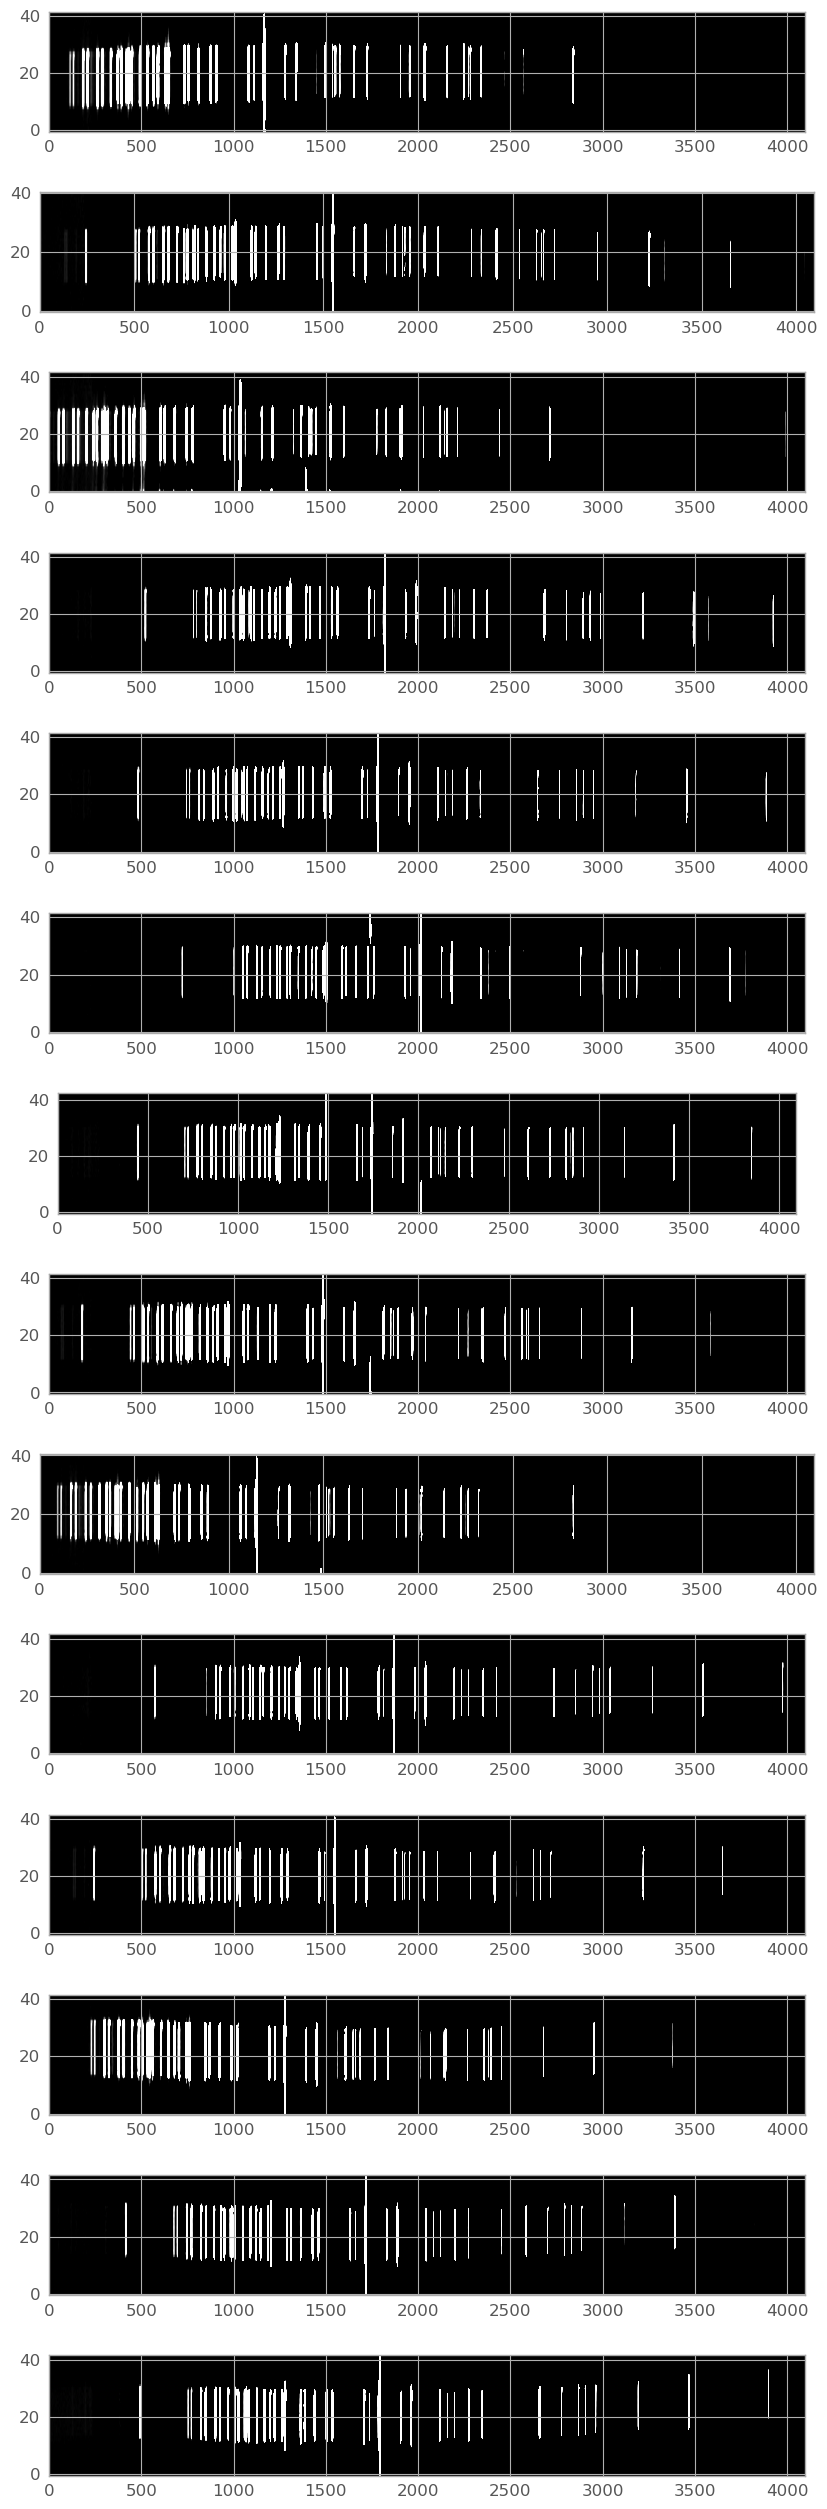

[327, 339, 356, 368] (41, 4094)


In [26]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(arc_good[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=0, vmax=1000,aspect='15.5')
    print(slits[i_s],arc_good[slits[i_s][0]:slits[i_s][3],:].shape)
plt.show()
print(slits[i_slit],arc_good[slits[i_slit][0]:slits[i_slit][3],:].shape)


# Repeat with the flats

[241, 253, 271, 283] (42, 4094)
[327, 339, 356, 368] (41, 4094)
[418, 430, 448, 460] (42, 4094)
[521, 533, 551, 563] (42, 4094)
[615, 627, 645, 657] (42, 4094)
[666, 678, 696, 708] (42, 4094)
[702, 714, 733, 745] (43, 4094)
[737, 749, 767, 779] (42, 4094)
[780, 792, 809, 821] (41, 4094)
[846, 858, 876, 888] (42, 4094)
[895, 907, 925, 937] (42, 4094)
[1175, 1187, 1205, 1217] (42, 4094)
[1263, 1275, 1293, 1305] (42, 4094)
[1315, 1327, 1345, 1357] (42, 4094)


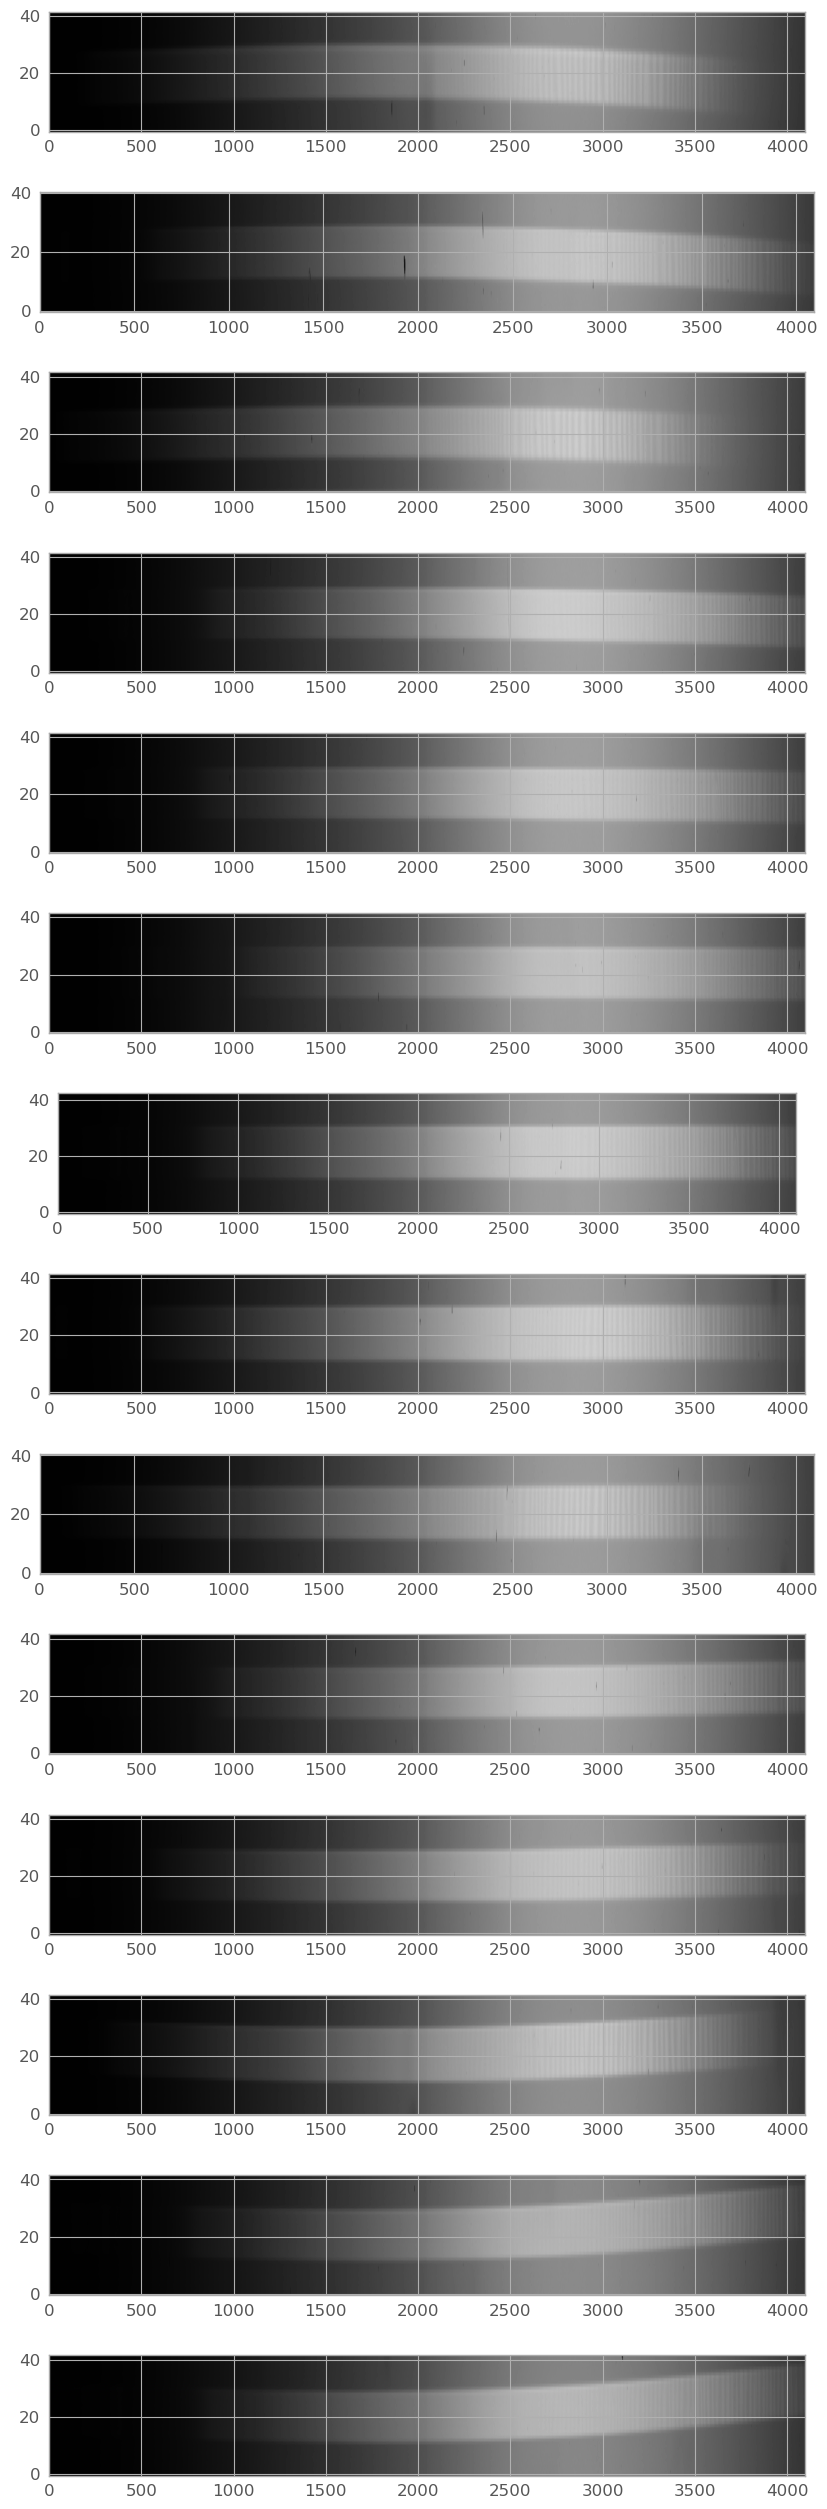

In [27]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(flat_bias[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=-100, vmax=20000,aspect='15.5')
    print(slits[i_s],flat_bias[slits[i_s][0]:slits[i_s][3],:].shape)
plt.show()

# Repeat with spectra

[241, 253, 271, 283] (42, 4094)
[327, 339, 356, 368] (41, 4094)
[418, 430, 448, 460] (42, 4094)
[521, 533, 551, 563] (42, 4094)
[615, 627, 645, 657] (42, 4094)
[666, 678, 696, 708] (42, 4094)
[702, 714, 733, 745] (43, 4094)
[737, 749, 767, 779] (42, 4094)
[780, 792, 809, 821] (41, 4094)
[846, 858, 876, 888] (42, 4094)
[895, 907, 925, 937] (42, 4094)
[1175, 1187, 1205, 1217] (42, 4094)
[1263, 1275, 1293, 1305] (42, 4094)
[1315, 1327, 1345, 1357] (42, 4094)


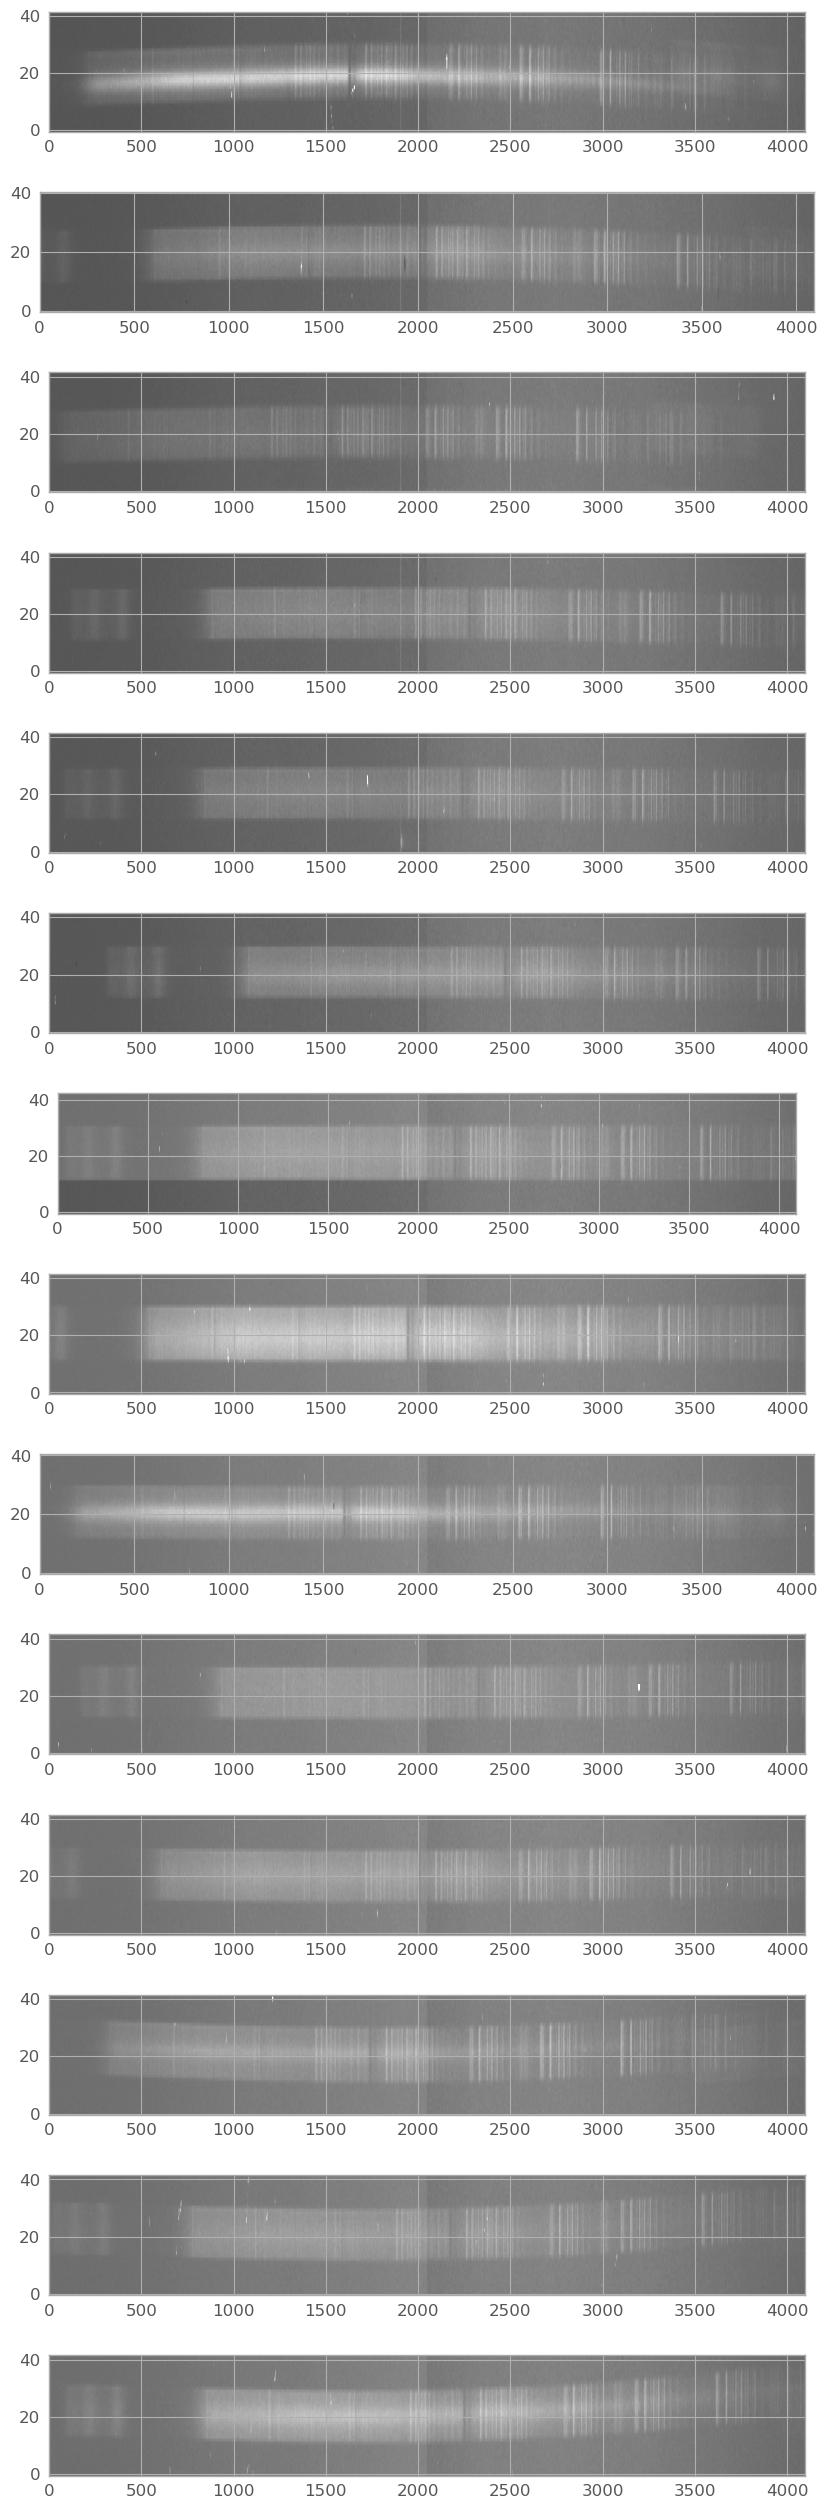

In [28]:
f, axarr = plt.subplots(len(slits),figsize=(20, 32))
#axarr.figure(figsize=(20,30))
for i_s in range(len(slits)):
    axarr[i_s].imshow(spectra_bias[slits[i_s][0]:slits[i_s][3],:], origin='lower', cmap='gray',vmin=-100, vmax=100,aspect='15.5')
    print(slits[i_s],spectra_bias[slits[i_s][0]:slits[i_s][3],:].shape)

plt.show()

(41, 4094)


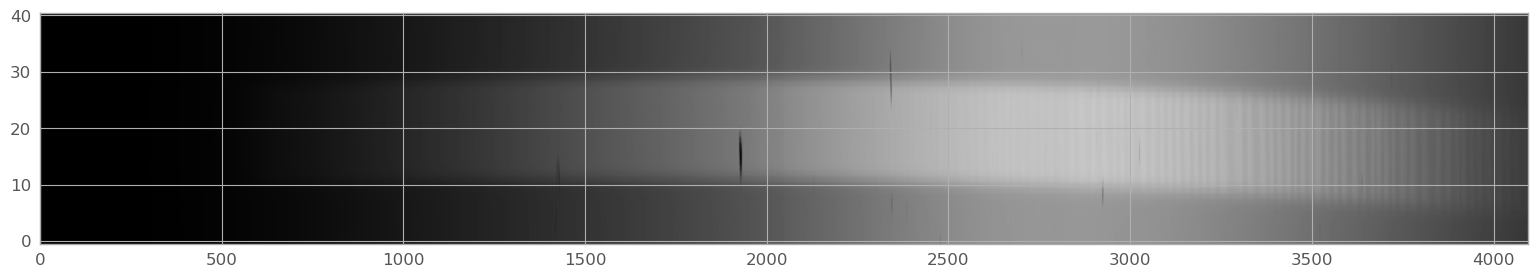

1


In [29]:
#first we inspect the situation

flat_bias_blur = cv2.GaussianBlur(flat_bias,(5,5), sigmaX=0, sigmaY=0)
plt.figure(figsize=(20,3))
slit = flat_bias_blur[slits[i_slit][0]:slits[i_slit][3],:]
print(slit.shape)

plt.imshow(slit, origin='lower', cmap='gray',vmin=0, vmax=20000,aspect='15.5')
#plt.gca().set_aspect(0.5)
plt.show()

print(i_slit)

In [30]:
i_s=0
for i_s in range(len(slits)):
    data = spectra_bias[slits[i_s][0]:slits[i_s][3],:]
    flat = flat_bias[slits[i_s][0]:slits[i_s][3],:]
    line = arc_good[slits[i_s][0]:slits[i_s][3],:]
    mask_in = arc_good[slits[i_s][0]:slits[i_s][3],:]
    
    #create header
    hdr = fits.Header()
    hdr['SLIT'] = i_s
    hdr['i0'] = (slits[i_s][0],'y[0] pixel of the 2d cut')
    hdr['i1'] = (slits[i_s][1],'y[0] pixel of the trace')
    hdr['i2'] = (slits[i_s][2],'y[1] pixel of the trace')
    hdr['i3'] = (slits[i_s][3],'y[1] pixel of the 2d cut')
    empty_primary = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(data=data, name="DATA")
    hdulist = fits.HDUList([empty_primary, image_hdu])
    #add flat
    flat_hdu = fits.ImageHDU(data=flat, name= "FLAT")
    hdulist.append(flat_hdu)
    #add lines
    line_hdu = fits.ImageHDU(data=line, name= "LINES")
    hdulist.append(line_hdu)

    print('\nmask = ',i_s)
    hdulist.info()
    hdulist.writeto(working_directory+'/spec_{i_s:03.0f}.fits'.format(i_s=i_s),overwrite=True)
    hdulist.close()


mask =  0
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  DATA          1 ImageHDU         8   (4094, 42)   float64   
  2  FLAT          1 ImageHDU         8   (4094, 42)   float64   
  3  LINES         1 ImageHDU         8   (4094, 42)   float64   

mask =  1
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  DATA          1 ImageHDU         8   (4094, 41)   float64   
  2  FLAT          1 ImageHDU         8   (4094, 41)   float64   
  3  LINES         1 ImageHDU         8   (4094, 41)   float64   

mask =  2
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  DATA          1 ImageHDU         8   (4094, 42)   float64   
  2  FLAT          